In [128]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [129]:
import numpy as np
import pandas as pd

In [130]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [131]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [132]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [133]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [134]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [135]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [136]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [137]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [138]:
measurement_columns=inspector.get_columns('measurement')
for column in measurement_columns:   
    print(column['name'],column['type'])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [139]:
station_columns=inspector.get_columns('measurement')
for column in station_columns:   
    print(column['name'],column['type'])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [140]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
yearlyrain = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
yearlyrain = yearlyrain[0]


In [141]:
# Calculate the date 1 year ago from the last data point in the database

previousyear = dt.datetime.strptime(yearlyrain, "%Y-%m-%d") - dt.timedelta(days=366)
previousyear

datetime.datetime(2016, 8, 22, 0, 0)

In [142]:
# Perform a query to retrieve the data and precipitation scores
yeardata = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= previousyear).all()
#yeardata

In [143]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(yeardata,columns=['date', 'precipitation'])
precip_df['date'] = pd.to_datetime(precip_df['date'], format='%Y-%m-%d')
precip_df['date']


0      2016-08-23
1      2016-08-24
2      2016-08-25
3      2016-08-26
4      2016-08-27
          ...    
2225   2017-08-19
2226   2017-08-20
2227   2017-08-21
2228   2017-08-22
2229   2017-08-23
Name: date, Length: 2230, dtype: datetime64[ns]

In [144]:
# Sort the dataframe by date
precip_df.set_index('date', inplace=True)

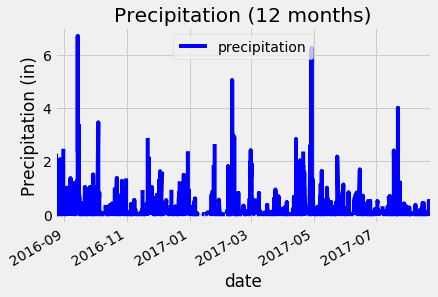

In [154]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(title="Precipitation (12 months)", color='b')
plt.figsize=(14,10)
plt.ylabel('Precipitation (in)')
plt.legend(loc='upper center')
plt.savefig("Precipitation.png")
plt.show()

![precipitation](Images/precipitation.png)

In [146]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [147]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [148]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by (Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [149]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

min_max_avg = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter (Measurement.station=='USC00519281').all()

min_max_avg

[(54.0, 85.0, 71.66378066378067)]

In [150]:
# Choose the station with the highest number of temperature observations.
most_observations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_observations = most_observations[0]

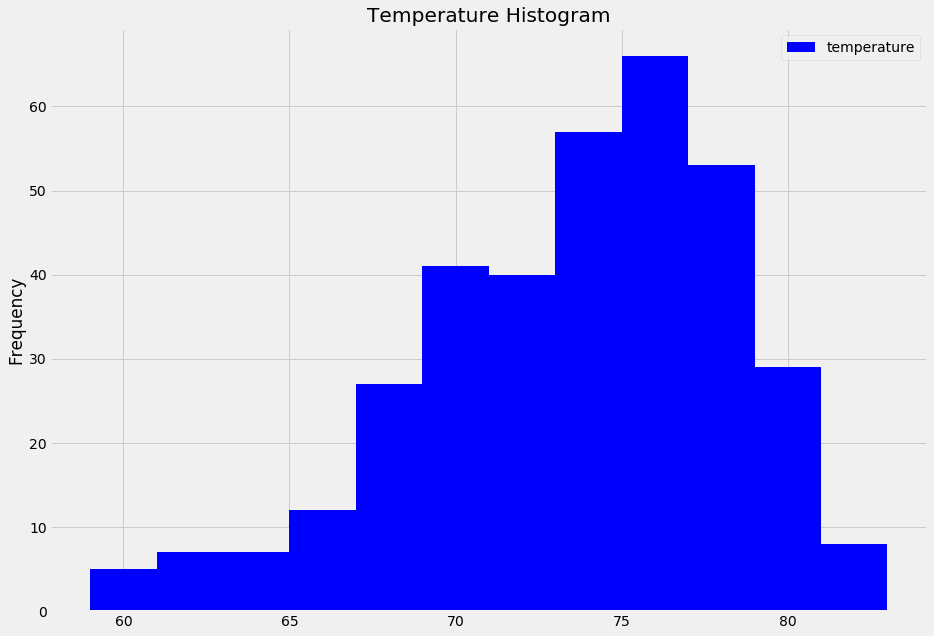

In [156]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observations = session.query(Measurement.tobs).filter(Measurement.date >= previousyear).filter(Measurement.station == most_observations).all()
temperature_observations_df = pd.DataFrame(temperature_observations, columns=['temperature'])
temperature_observations_df.plot.hist(title="Temperature Histogram",color='blue', figsize=(14,10), bins=12)
plt.savefig("TemperaturevsFrequency.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [167]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [169]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-06-03','2017-06-12')
trip_temps

[(72.0, 77.390625, 83.0)]

Text(0, 0.5, 'Temp (F)')

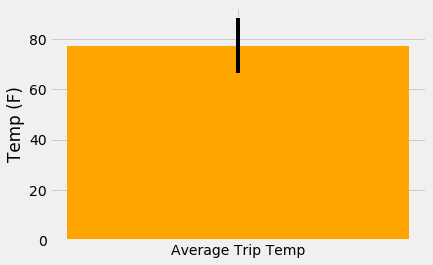

In [177]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_err = trip_temps[0][2] - trip_temps[0][0]

plt.bar('Average Trip Temp', trip_temps[0][1], yerr = trip_err, color = "orange")
plt.title = ('Trip Avg Temp')
plt.ylabel('Temp (F)')


In [180]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_precipitation = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp))\
                .select_from(Measurement).join(Station, Station.station == Measurement.station)\
                .filter(Measurement.date > '2017-06-03')\
                .filter(Measurement.date < '2017-06-12')\
                .group_by(Station.station)\
                .order_by(Measurement.prcp.desc()).all()
trip_precipitation

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.54),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.6399999999999999),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.56),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.75),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.38),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.12),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [162]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [159]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [160]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [161]:
# Plot the daily normals as an area plot with `stacked=False`
